### Some examples with (distant) galaxies

Some simulations with galaxies at z=1.5

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

import simcado
from simcado import __data_dir__
print("SimCADO data directory is", __data_dir__)

import photutils

SimCADO data directory is /home/mverdugo/simcado_work/simcado/data


Let's first give a look to the SED capabilities of SimCADO.

In [2]:
print("Available SEDs in SimCADO. You can add more with simcado.utils.add_SED_to_simcado")

simcado.source.get_SED_names()

Available SEDs in SimCADO. You can add more with simcado.utils.add_SED_to_simcado


['starburst',
 'ulirg',
 'elliptical',
 'spiral',
 'interacting',
 'All stellar spectral types (e.g. G2V, K0III)']

### Properties of the simulated galaxies

We are going to simulate disk galaxies at z~1.5, that is galaxies with sersic index n=1

At $z\sim 1.5$ a $L^\star$ galaxy will have an apparent magnitude of $Ks \approx 19.0$ in the Vega system (https://doi.org/10.1051/0004-6361/201015251 ) with a stellar mass of $\log(M_\star) \sim 10.5$ 

A galaxy with $\log(M_\star) \sim 9.5$  would have therefore a magnitude $Ks \approx 19.0 + 2.5$ assuming a similar $M/L$ ratio

The effective radius of these galaxies would be $R_{eff} \sim 4$kpc and $R_{eff} \sim 2$kpc respectively (https://iopscience.iop.org/article/10.1088/0004-637X/788/1/28)

In [3]:
# writing down these parameters

z = 1.5  # redshift
scale = cosmo.kpc_proper_per_arcmin(z)/60

magKs_gal1  = 19.2  
magKs_gal2  = magKs_gal1 + 2.5 

reff_gal1 = 4  / scale.value
reff_gal2 = 2  / scale.value

# We need to create a Emission Curve object to use it in source.spiral, see below
ec_gal1 = simcado.source.redshift_SED(z,"spiral", magKs_gal1, "TC_filter_Ks.dat")
ec_gal2 = simcado.source.redshift_SED(z,"spiral", magKs_gal2, "TC_filter_Ks.dat")

In [4]:
# Creating the source objects to be used in the simulation

src_gal1 = simcado.source.elliptical(half_light_radius=reff_gal1,    # in arcsec
                                     plate_scale=0.004,              # in arcsec
                                     magnitude=magKs_gal1,           # in the vega system 
                                     filter_name='TC_filter_Ks.dat',
                                     normalization='total', 
                                     spectrum=ec_gal1,
                                     ellipticity=0.5, 
                                     n=1)                            # sersic index

src_gal2 = simcado.source.elliptical(half_light_radius=reff_gal2,    # in arcsec
                                     plate_scale=0.004,              # in arcsec
                                     magnitude=magKs_gal2,           # in the vega system 
                                     filter_name='TC_filter_Ks.dat',
                                     normalization='total', 
                                     spectrum=ec_gal2,
                                     ellipticity=0.5,              
                                     n=1)                          # sersic index

In [5]:
# Runing the simulation with two hours of exposure time

t_exp = 3600 * 2 # seconds

sp_gal1  = simcado.run(src_gal1, OBS_NDIT=1, OBS_DIT=t_exp, SIM_DETECTOR_PIX_SCALE=0.004,
                       INST_FILTER_TC='TC_filter_Ks.dat', SCOPE_PSF_FILE= "SCAO",
                       FPA_LINEARITY_CURVE=None)

sp_gal2  = simcado.run(src_gal2, OBS_NDIT=1, OBS_DIT=t_exp, SIM_DETECTOR_PIX_SCALE=0.004,
                       INST_FILTER_TC='TC_filter_Ks.dat', SCOPE_PSF_FILE= "SCAO",
                       FPA_LINEARITY_CURVE=None)

# Detector linearity turned off 

Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast


Sky level is:  323945.25 323943.53 respectively


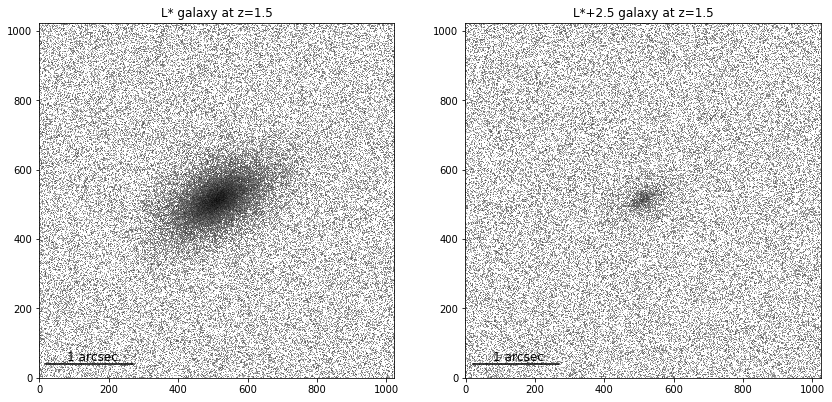

In [6]:
# Working a bit with the data

gal1_data = sp_gal1[0].data 
gal2_data = sp_gal2[0].data

# First subtract the background
sky_gal1 = np.median(gal1_data[0:200,:])
sky_gal2 = np.median(gal2_data[0:200,:])
print("Sky level is: ", sky_gal1, sky_gal2, "respectively")

# Normalize the images to counts per second
gal1_norm = (gal1_data - sky_gal1) / t_exp 
gal2_norm = (gal2_data - sky_gal2) / t_exp  

fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(121)
ax1.imshow(gal1_norm, origin="lower", cmap="gray_r", norm=LogNorm(vmin=0.01, vmax=1))
ax1.set_title("L* galaxy at z=1.5")
ax1.plot([20,250+20],[40,40],"k")
ax1.text(80, 50, "1 arcsec", fontsize=12)

ax2 = plt.subplot(122)
ax2.imshow(gal2_norm, origin="lower", cmap="gray_r", norm=LogNorm(vmin=0.01, vmax=1))
ax2.set_title("L*+2.5 galaxy at z=1.5")

ax2.plot([20,250+20],[40,40],"k")
ax2.text(80, 50, "1 arcsec", fontsize=12)
fig.savefig("galaxies.png")

### A bit of photometry with photutils

Notice the different scales


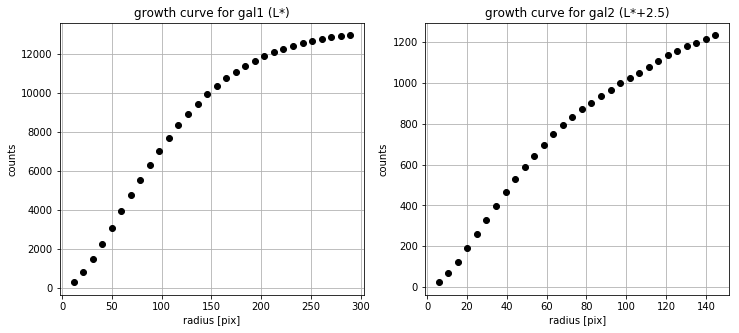

In [7]:

# Defining the radii of the apertures
r_gal1 = reff_gal1 * np.linspace(0.1, 2.5, 30) / 0.004  # 2xReff 
r_gal2 = reff_gal2 * np.linspace(0.1, 2.5, 30) / 0.004  # 2xReff 

center = (512.5, 512.5)

# creating the apertures
aper1 = [photutils.CircularAperture(center, r=r) for r in r_gal1]
aper2 = [photutils.CircularAperture(center, r=r) for r in r_gal2]

# Performing photometry
phot_table1 = photutils.aperture_photometry(gal1_norm, aper1)
phot_table2 = photutils.aperture_photometry(gal2_norm, aper2)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# plotting the results
for i in range(len(r_gal1)):
    counts1 = phot_table1[0][i+3]
    counts2 = phot_table2[0][i+3]
    r1 = r_gal1[i] 
    r2 = r_gal2[i]
    ax1.plot(r1, counts1, 'o', color='k')
    ax2.plot(r2, counts2, 'o', color='k')

ax1.set_xlabel("radius [pix]")
ax2.set_xlabel("radius [pix]")
ax1.set_ylabel("counts")
ax2.set_ylabel("counts")
ax1.set_title("growth curve for gal1 (L*)")
ax2.set_title("growth curve for gal2 (L*+2.5)")
ax1.grid()
ax2.grid()
print("Notice the different scales")

**Zeropoint for filter TC_filter_Ks.dat is 29.491 magnitudes. see simcado.simulation.zeropoint()**

Red lines show the input magnitudes


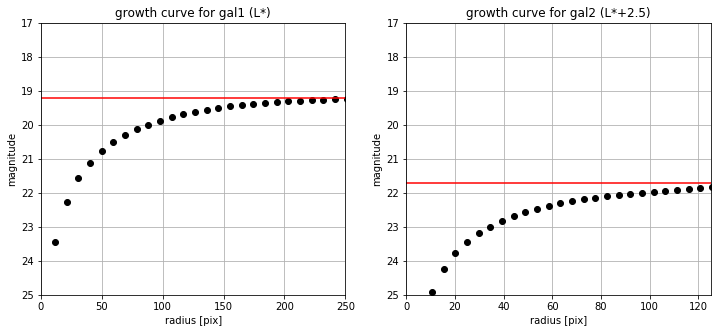

In [8]:
zp  = 29.491   # Obtained from simcado.simulation.zeropoint()

# repeating the plots with magnitudes
fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in range(len(r_gal1)):
    counts1 = phot_table1[0][i+3]
    counts2 = phot_table2[0][i+3]
    r1 = r_gal1[i] 
    r2 = r_gal2[i]
    mag1 = -2.5*np.log10(counts1) + zp
    mag2 = -2.5*np.log10(counts2) + zp
    ax1.plot(r1, mag1, 'o', color='k')
    ax2.plot(r2, mag2, 'o', color='k')

ax1.set_xlabel("radius [pix]")
ax2.set_xlabel("radius [pix]")
ax1.set_ylabel("magnitude")
ax2.set_ylabel("magnitude")
ax1.set_title("growth curve for gal1 (L*)")
ax2.set_title("growth curve for gal2 (L*+2.5)")
ax1.set_xlim(0,250)
ax2.set_xlim(0,125)
ax1.set_ylim(25,17)
ax2.set_ylim(25,17)
ax1.grid()
ax2.grid()
ax1.plot([0,500],[magKs_gal1, magKs_gal1], 'r')
ax2.plot([0,500],[magKs_gal2, magKs_gal2], 'r')
print("Red lines show the input magnitudes")
fig.savefig("magnitudes.png")

## Experiment with simcado.source.source_from_image

simcado.source.source_from_image() takes as a main argument an image (2D array of fluxes) and creates a source object. The image is rescaled to an input magnitude and a threshold is used to ignore low value fluxes. This means that all pixels above that threshold count towards the total flux and therefore can be thought as a single object. This should be enough for many situations (e.g. simulation data)

For the simulation we are going to use high quality HAWK-I data of the galaxy NGC 1232

Data was obtained from here: http://archive.eso.org/dataset/ADP.2016-07-26T11:56:15.236

The distance to this galaxy is 19.8 Mpc according to NED

In [9]:
download_dir = "/home/mverdugo/Downloads/"  # Change for your download directory
filename = "ADP.2016-07-26T11_56_15.236.fits"

data = fits.getdata(os.path.join(download_dir, filename))

size of the image (4538, 4554)


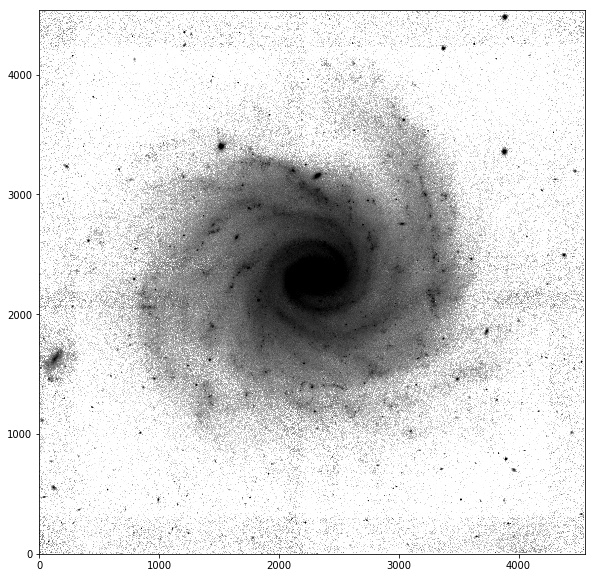

In [10]:
# Plotting 
fig=plt.figure(figsize=(10,10))
image = data - np.median(data[0:200,:])
plt.imshow(image, origin="lower", cmap="gray_r", norm=LogNorm(vmin=5, vmax=250))
print("size of the image", image.shape)
fig.savefig("NGC1232.png")

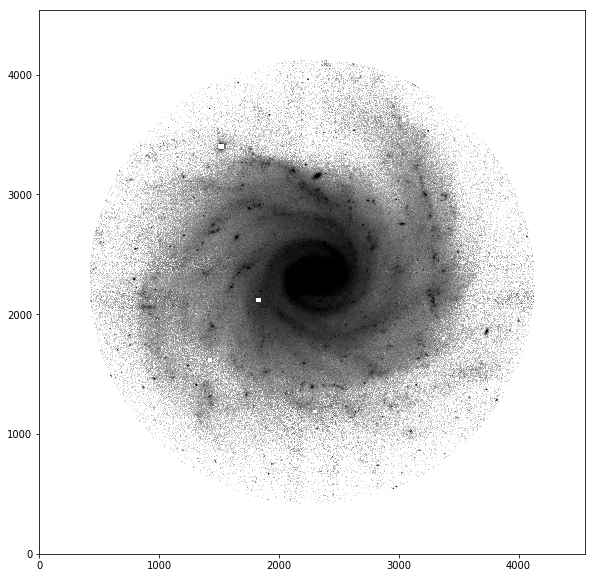

In [11]:
# Masking few bright objects in the field
arr = np.where(image>5250)
for x, y in zip(arr[0], arr[1]):
        x1, x2 = x-15, x+15
        y1, y2 = y-15, y+15
        image[x1:x2,y1:y2] = 0

# And masking a circular region around the center to exclude unwanted noise and unrelated objects
lx, ly = image.shape
X, Y = np.ogrid[0:lx, 0:ly]
mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 6
image[mask] = 0

# Plotting again
fig=plt.figure(figsize=(10,10))
plt.imshow(image, origin="lower", cmap="gray_r", norm=LogNorm(vmin=5, vmax=250))

In [12]:
# Calculating pixel size in kpc for that image
angle = 0.106            # HAWK-I pixel size
distance = 19.8 * u.Mpc  # from NED

# SimCADO utility function to calculate the transverse distance. Don't use for cosmological distances
scale_hawki = simcado.utils.transverse_distance(angle, distance)
print("Scale is:", scale_hawki.to(u.kpc), " per pixel")

Scale is: 0.010175269539206664 kpc  per pixel


In [13]:
# Lets put this galaxy at redshift 1.5 using some of the above information

scale_micado = 0.004 * cosmo.kpc_proper_per_arcmin(z)/60
print("MICADO scale at z=1.5 is:", scale_micado.value, "kpc/per pixel")

scale_factor = scale_hawki.to(u.kpc).value / scale_micado.value
to_micado_plate_scale = 0.004 * scale_factor / 2 # Factor 2 because otherwise galaxy might be too big for z>1

MICADO scale at z=1.5 is: 0.03453228980407426 kpc/per pixel


In [14]:
# Creating the source
src_galaxy = simcado.source.source_from_image(image, ec_gal1.lam, ec_gal1.val, # spectra
                                       plate_scale=to_micado_plate_scale, # The plate scale of the simulated image
                                       flux_threshold=25)  # Pixels with counts less than 25 are not considered

In [15]:
sp_gal2h  = simcado.run(src_galaxy, OBS_NDIT=1, OBS_DIT=t_exp, SIM_DETECTOR_PIX_SCALE=0.004,
                        INST_FILTER_TC='TC_filter_Ks.dat', SCOPE_PSF_FILE= "SCAO",
                        FPA_LINEARITY_CURVE=None)
sp_gal20h  = simcado.run(src_galaxy, OBS_NDIT=1, OBS_DIT=t_exp*10, SIM_DETECTOR_PIX_SCALE=0.004,
                         INST_FILTER_TC='TC_filter_Ks.dat', SCOPE_PSF_FILE= "SCAO",
                         FPA_LINEARITY_CURVE=None)

Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast


Sky level is:  323944.44 3239442.0  respectively

NGC 1232 at z=1.5 with a magnitude Ks=19.32


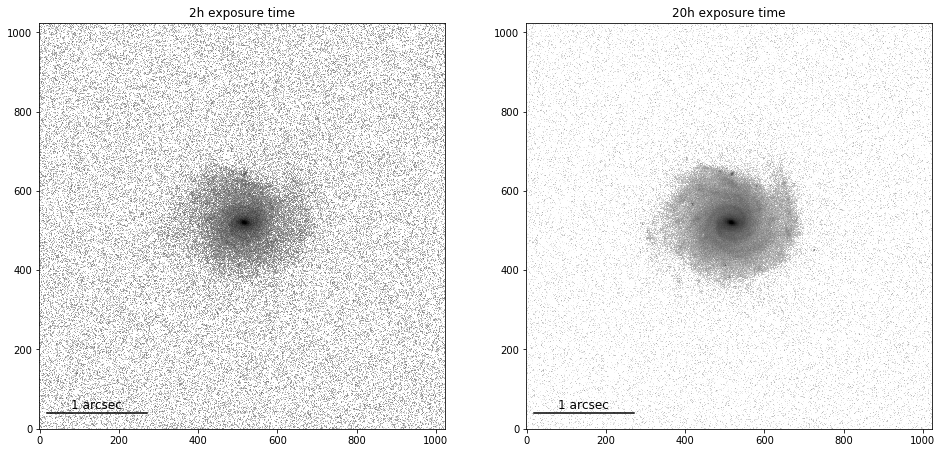

In [16]:
# Working with the simulated data

gal2h_data = sp_gal2h[0].data 
gal20h_data = sp_gal20h[0].data

# First subtract the background
sky_gal2h = np.median(gal2h_data[0:200,:])
sky_gal20h = np.median(gal20h_data[0:200,:])

print("Sky level is: ", sky_gal2h, sky_gal20h, " respectively")

# And normalize the counts to 1s
gal2h_norm = (gal2h_data - sky_gal2h) / t_exp 
gal20h_norm = (gal20h_data - sky_gal20h) / (t_exp*10)

print()
print("NGC 1232 at z=1.5 with a magnitude Ks=19.32")
fig=plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
ax1.imshow(gal2h_norm, origin="lower", cmap="gray_r", norm=LogNorm(vmin=0.02, vmax=2))
ax1.set_title("2h exposure time")
ax1.plot([20,250+20],[40,40],"k")
ax1.text(80, 50, "1 arcsec", fontsize=12)

ax2 = plt.subplot(122)
ax2.imshow(gal20h_norm, origin="lower", cmap="gray_r", norm=LogNorm(vmin=0.02, vmax=2))
ax2.set_title("20h exposure time")
ax2.plot([20,250+20],[40,40],"k")
ax2.text(80, 50, "1 arcsec", fontsize=12)
fig.savefig("NGC1232_z15.png")

Red lines show the input magnitudes


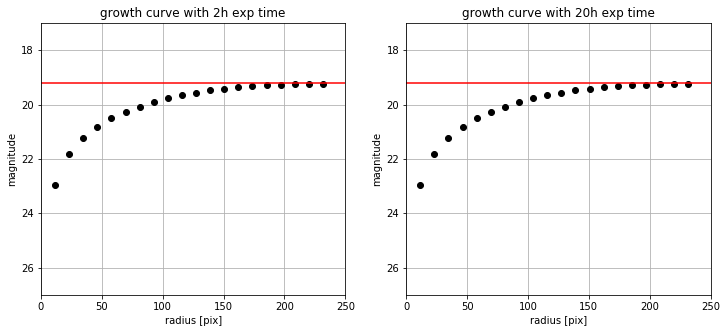

In [17]:
r_gal1 = reff_gal1 * np.linspace(0.1, 2, 20) / 0.004  # 2xReff 
r_gal2 = reff_gal1 * np.linspace(0.1, 2, 20) / 0.004  # 2xReff 

center = (512.5, 512.5)

aper1 = [photutils.CircularAperture(center, r=r) for r in r_gal1]
aper2 = [photutils.CircularAperture(center, r=r) for r in r_gal2]

phot_table1 = photutils.aperture_photometry(gal2h_norm, aper1)
phot_table2 = photutils.aperture_photometry(gal20h_norm, aper2)

fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for i in range(len(r_gal1)):
    counts1 = phot_table1[0][i+3]
    counts2 = phot_table2[0][i+3]
    r1 = r_gal1[i] 
    r2 = r_gal2[i]
    mag1 = -2.5*np.log10(counts1) + zp
    mag2 = -2.5*np.log10(counts2) + zp
    ax1.plot(r1, mag1, 'o', color='k')
    ax2.plot(r2, mag2, 'o', color='k')

ax1.set_xlabel("radius [pix]")
ax2.set_xlabel("radius [pix]")
ax1.set_ylabel("magnitude")
ax2.set_ylabel("magnitude")
ax1.set_title("growth curve with 2h exp time")
ax2.set_title("growth curve with 20h exp time")
ax1.set_xlim(0,250)
ax2.set_xlim(0,250)
ax1.set_ylim(27,17)
ax2.set_ylim(27,17)
ax1.grid()
ax2.grid()
ax1.plot([0,500],[magKs_gal1, magKs_gal1], 'r')
ax2.plot([0,500],[magKs_gal1, magKs_gal1], 'r')
print("Red lines show the input magnitudes")

### Finally lets put a point source in the center

e.g. an QSO 

(we do not have yet a QSO SED, so we are going to model it simple as a star)

In one case the QSO will have the same luminosity as the galaxy
In the second the lumonosity will be 10 times larger (i.e. 2.5 mags brighter)


In [18]:

qso1x = simcado.source.point_source(spectrum='A0V', mag=magKs_gal1, filter_name='TC_filter_Ks.dat')
qso10x = simcado.source.point_source(spectrum='A0V', mag=magKs_gal1-2.5, filter_name='TC_filter_Ks.dat')

# Here we combine the two sources
combined_with_qso1x =  qso1x + src_galaxy 
combined_with_qso10x = src_galaxy + qso10x

In [19]:
qso1x  = simcado.run(combined_with_qso1x, OBS_NDIT=1, OBS_DIT=t_exp*10, SIM_DETECTOR_PIX_SCALE=0.004,
                        INST_FILTER_TC='TC_filter_Ks.dat', SCOPE_PSF_FILE= "SCAO",
                        FPA_LINEARITY_CURVE=None)
qso10x  = simcado.run(combined_with_qso10x, OBS_NDIT=1, OBS_DIT=t_exp*10, SIM_DETECTOR_PIX_SCALE=0.004,
                         INST_FILTER_TC='TC_filter_Ks.dat', SCOPE_PSF_FILE= "SCAO",
                         FPA_LINEARITY_CURVE=None)


Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast


Sky level is:  323944.44 3239442.0  respectively


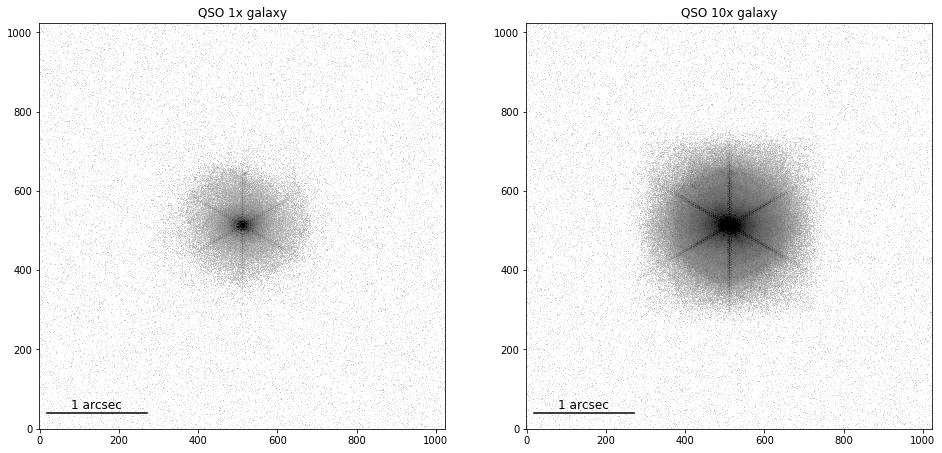

In [20]:
# Working with the simulated data

qso1x_data = qso1x[0].data 
qso10x_data = qso10x[0].data

# First subtract the background
sky1x_dat = np.median(qso1x_data[0:200,:])
sky10x_dat = np.median(qso10x_data[0:200,:])

print("Sky level is: ", sky_gal2h, sky_gal20h, " respectively")

# And normalize the counts to 1s
qso1x_norm = (qso1x_data - sky10x_dat) / (t_exp * 10)
qso10x_norm = (qso10x_data - sky10x_dat) / (t_exp * 10)

fig=plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
ax1.imshow(qso1x_norm, origin="lower", cmap="gray_r", norm=LogNorm(vmin=0.02, vmax=4))
ax1.set_title("QSO 1x galaxy")
ax1.plot([20,250+20],[40,40],"k")
ax1.text(80, 50, "1 arcsec", fontsize=12)

ax2 = plt.subplot(122)
ax2.imshow(qso10x_norm, origin="lower", cmap="gray_r", norm=LogNorm(vmin=0.02, vmax=4))
ax2.set_title("QSO 10x galaxy")
ax2.plot([20,250+20],[40,40],"k")
ax2.text(80, 50, "1 arcsec", fontsize=12)
fig.savefig("QSO_galaxy.png")